In [2]:
from google.colab import files
uploaded = files.upload()

Saving 01000_lr.dat to 01000_lr.dat
Saving 01000_lr.hea to 01000_lr.hea
Saving 01001_lr.dat to 01001_lr.dat


In [5]:
from google.colab import files
uploaded = files.upload()

Saving scp_statements.csv to scp_statements.csv


In [11]:
from google.colab import files
uploaded = files.upload()

Saving ptbxl_database.csv to ptbxl_database (1).csv


Loaded 'ptbxl_database.csv' → shape (rows,cols): (21799, 10)
Numeric columns used: ['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'validated_by', 'strat_fold']
After imputation & scaling → X shape: (21799, 10)

k	inertia
2	183802.5979
3	159440.5085
4	141523.7461
5	126753.0135
6	112617.4210
7	103672.8304
8	97451.9636
9	92308.6318
10	88487.2640
11	84850.5343
12	81737.4874
13	78632.6577
14	76328.8496
15	73462.7577
16	71547.9424
17	69298.2179
18	68039.3489
19	65123.1619
20	64503.9088


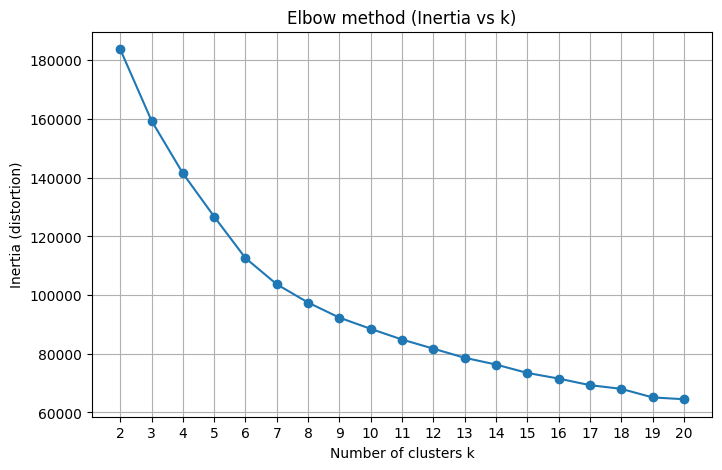

In [28]:
# A7:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# -------------------------
# Functions (no prints here)
# -------------------------
def load_numeric_dataframe(csv_path, use_features=None):
    """
    Load CSV and return a DataFrame with numeric columns (or only columns in use_features).
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File not found: {csv_path}")

    df = pd.read_csv(csv_path)
    if use_features:
        missing = [c for c in use_features if c not in df.columns]
        if missing:
            raise KeyError(f"Requested features not found in CSV: {missing}")
        df_num = df[use_features].copy()
    else:
        # select numeric columns only
        df_num = df.select_dtypes(include=[np.number]).copy()

    if df_num.shape[1] == 0:
        raise ValueError("No numeric columns found. Provide numeric feature names or check CSV.")

    return df_num


def preprocess_for_clustering(df_numeric, impute_strategy='mean'):
    """
    Impute missing values and scale features. Returns scaled numpy array.
    """
    # Impute missing values
    imputer = SimpleImputer(strategy=impute_strategy)
    X_imputed = imputer.fit_transform(df_numeric.values)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    return X_scaled, imputer, scaler


def compute_inertia_for_k_range(X, k_min=2, k_max=20, random_state=42, n_init=10, max_iter=300):
    """
    Compute KMeans inertia (distortion) for k values in [k_min, k_max] inclusive.
    Returns list of ks and corresponding inertias.
    """
    if X.shape[0] < 2:
        raise ValueError("Not enough samples to run clustering (need at least 2 rows).")
    # ensure k_max is sensible
    max_possible_k = min(k_max, X.shape[0] - 1)
    ks = list(range(k_min, max_possible_k + 1))
    inertias = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=n_init, max_iter=max_iter)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    return ks, inertias


def plot_elbow(ks, inertias, save_path=None, title="Elbow method (Inertia vs k)"):
    """
    Plot elbow curve. If running in headless environment, saves to save_path.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(ks, inertias, marker='o')
    plt.xticks(ks)
    plt.xlabel("Number of clusters k")
    plt.ylabel("Inertia (distortion)")
    plt.title(title)
    plt.grid(True)
    try:
        plt.show()
    except Exception:
        # fallback: save figure
        if save_path is None:
            save_path = "elbow_plot.png"
        plt.savefig(save_path)
        plt.close()
        return save_path
    return None

# -------------------------
# Main (prints only here)
# -------------------------
if __name__ == "__main__":
    # Change these paths/options as needed
    csv_path = "ptbxl_database.csv"
    # use_features = ['age','height','weight']   # <- optionally restrict to specific numeric cols
    use_features = None   # None = autodetect ALL numeric columns
    k_min = 2
    k_max = 20
    random_state = 42
    n_init = 10

    try:
        # Load numeric dataframe
        df_numeric = load_numeric_dataframe(csv_path, use_features=use_features)
        print(f"Loaded '{csv_path}' → shape (rows,cols): {df_numeric.shape}")
        print("Numeric columns used:", df_numeric.columns.tolist())

        # Preprocess (impute + scale)
        X_scaled, imputer, scaler = preprocess_for_clustering(df_numeric)
        print(f"After imputation & scaling → X shape: {X_scaled.shape}")

        # Ensure k_max not too large
        if k_max >= X_scaled.shape[0]:
            k_max_adj = X_scaled.shape[0] - 1
            print(f"Warning: requested k_max={k_max} is >= number of samples. Adjusting k_max to {k_max_adj}.")
            k_max = k_max_adj

        # Compute inertia for k range
        ks, inertias = compute_inertia_for_k_range(
            X_scaled, k_min=k_min, k_max=k_max, random_state=random_state, n_init=n_init
        )

        # Print results in tabular form
        print("\nk\tinertia")
        for k_val, inertia in zip(ks, inertias):
            print(f"{k_val}\t{inertia:.4f}")

        # Plot elbow; if saved, path is returned
        saved_path = plot_elbow(ks, inertias, save_path="elbow_plot.png")
        if saved_path:
            print(f"Plot could not be shown inline; saved to: {saved_path}")

    except Exception as e:
        # Provide helpful error feedback — paste this traceback to me if you need more help
        print("ERROR:", type(e).__name__, str(e))
        import traceback
        traceback.print_exc()
